# Hypotheses on Pixel Art Generation

This notebook evaluates the models that implement the hypotheses of representing images as indices in a palette, adding a histogram loss term to the generator, and the post-process step of quantizing to the palette.

We proposed both the palette representation and the histogram loss models for the AIIDE'22 paper and the palette-quantization step for the GMOD'24 article. I trained the AIIDE'22 models again (on july/24) so we could use the new codebase and evaluate (and generate images and tables) using all three hypotheses. 

In [1]:
import logging_utils
import tensorflow as tf

tf.random.set_seed(42)

from ModelProxy import Pix2PixModelProxy, IndexedPix2PixModelProxy

logging_utils.configure()

model_loaders = {
    "Palette Repres.": lambda: IndexedPix2PixModelProxy("models/pixel-art-hypotheses/indexed"),
    "Baseline": lambda: Pix2PixModelProxy("models/pixel-art-hypotheses/baseline"),
    "Baseline+P. Process": lambda: Pix2PixModelProxy("models/pixel-art-hypotheses/baseline", post_process=True),
    "Histogram Loss": lambda: Pix2PixModelProxy("models/pixel-art-hypotheses/histogram"),
    "Histogram+P. Process": lambda: Pix2PixModelProxy("models/pixel-art-hypotheses/histogram", post_process=True)
}

## Loads the RMXP Dataset

These tests use the RMXP dataset, as it is one of the most difficult due to its reduced size and high variability.


In [2]:
from dataset_utils import DatasetLoader

train_dataset_loader = DatasetLoader("rpg-maker-xp", "train", limit=None)
test_dataset_loader = DatasetLoader("rpg-maker-xp", "test", limit=None)

## Generates Images for a Qualitative Analysis


2024-07-10 18:50:03 WARNING  5 out of the last 5 calls to <function DatasetLoader.load_paired_images at 0x00000148D2D94048> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2024-07-10 18:50:03 WARNING  6 out of the last 6 calls to <function DatasetLoader.load_paired_images at 0x00000148D2D94048> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2024-07-10 18:50:05 INFO     Start >> Loading Pix2Pix model front-to-right
D:\Projetos 2\dissertation-notebooks\.venv\lib\site-packages\keras\initializers\initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each ti

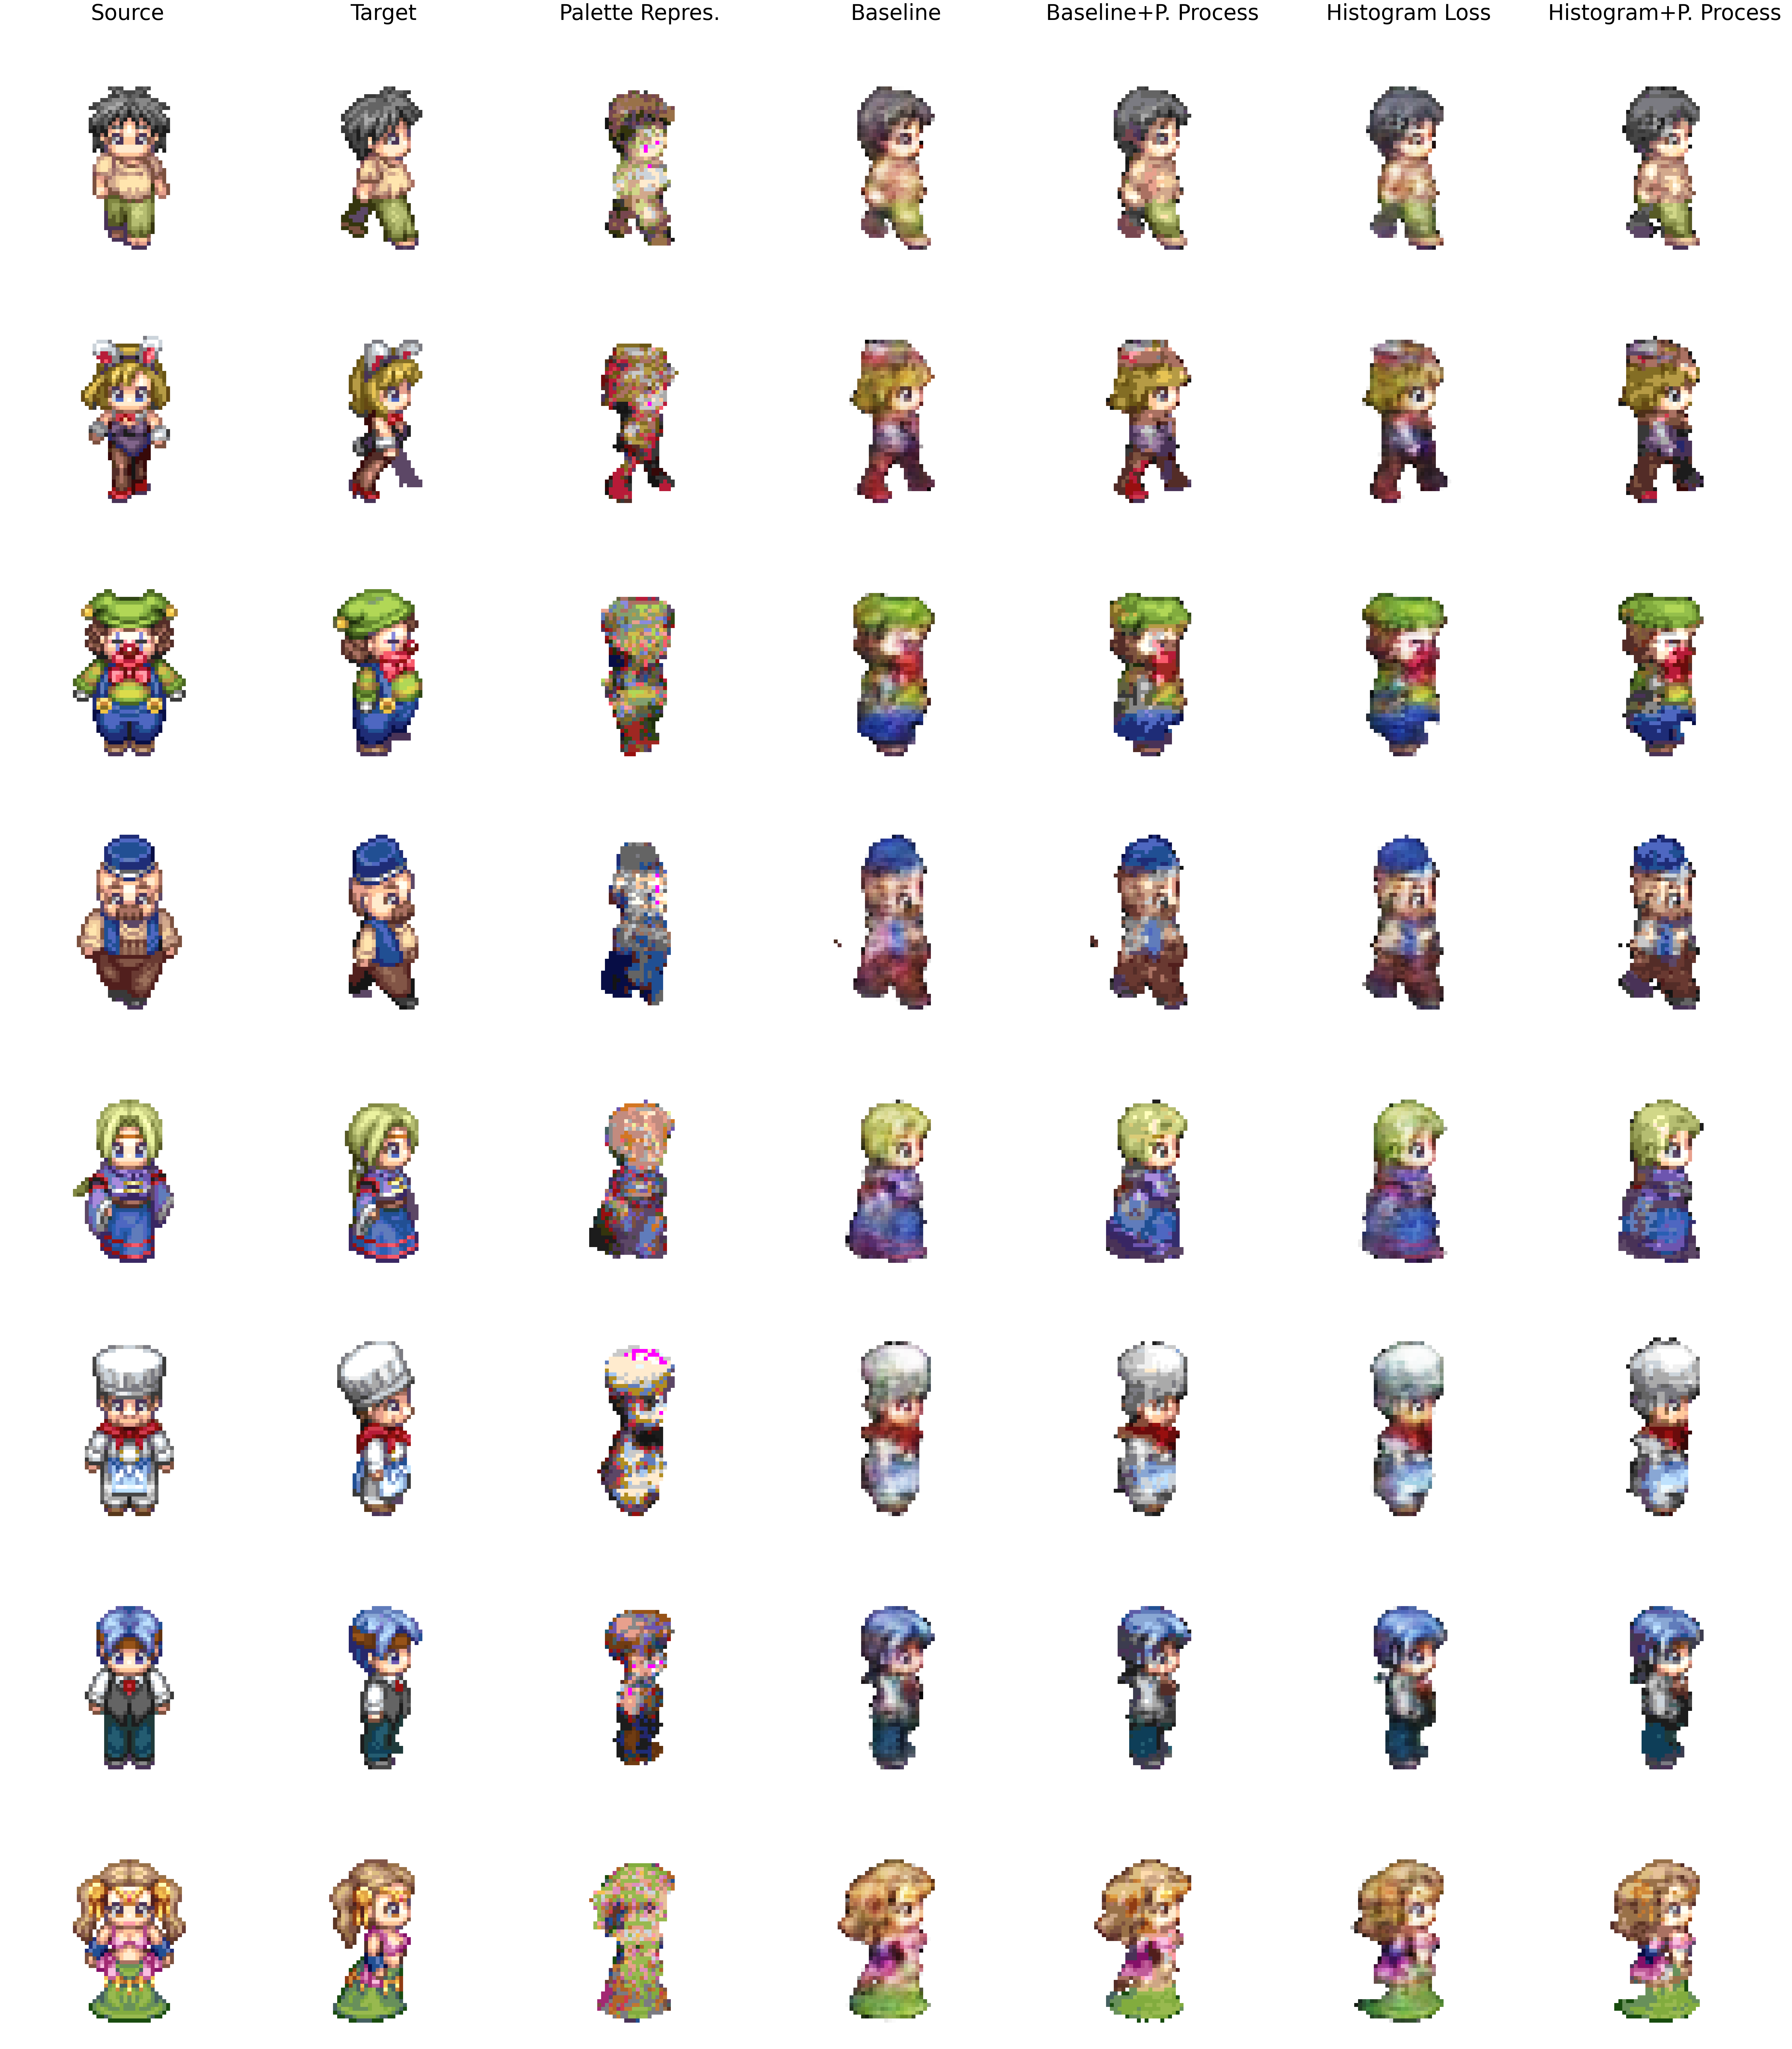

In [3]:
import tensorflow as tf
from image_utils import show_single_input_model_comparison


def generate_images_with_hypotheses(ds_loader, sample_numbers):
    batch = [ds_loader.load_paired_images(sample_number) for sample_number in sample_numbers]
    batch = tf.stack(batch, axis=0)
    batch_transpose = tf.transpose(batch, [1, 0, 2, 3, 4])

    source_images = tf.gather(batch_transpose, 2)
    target_images = tf.gather(batch_transpose, 3)
    genned_images = []
    model_names = list(model_loaders.keys())
    
    for model_name, loader in model_loaders.items():
        model = loader()
        genned_images.append(model.generate(2, 3, batch_transpose))
        del model
        
    return source_images, target_images, genned_images, "", model_names 


# example_indices = [0, 3, 9, 20, 34]
example_indices = [28, 2, 9, 37, 16, 6, 0, 12]
imgs_params = generate_images_with_hypotheses(test_dataset_loader, example_indices)
show_single_input_model_comparison(*imgs_params)


## Calculate FID and L1 Metrics?

In [4]:
import gc
import evaluation_metrics
import numpy as np
from time import time
import logging

# PARTITIONS = ["train", "test"]
PARTITIONS = ["test"]
DOMAINS = ["back", "left", "front", "right"]
source_domain = 2
target_domain = 3
source_domain_name = DOMAINS[source_domain]
target_domain_name = DOMAINS[target_domain]

metrics = {
    model_name: {
        partition: [0, 0]
        for partition in PARTITIONS
    }
    for model_name in model_loaders.keys()
}




evaluation_metrics.preload()

fake_images_per_model = {p:[] for p in PARTITIONS}
for model_name, model_loader in model_loaders.items():
    model_start_time = time()
    logging.info(f"Start >> Using {model_name}")
    logging.info(f"Start >> Loading {model_name}")
    generator = model_loader()
    logging.info(f"End   >> Loading {model_name}")
    
    for partition in PARTITIONS:
        batch_size = 128
        dataset_loader = train_dataset_loader if partition == "train" else test_dataset_loader
        all_images = np.stack(list(dataset_loader.dataset))
        target_images = all_images[:, target_domain]
        source_images = all_images[:, source_domain]
        
        logging.debug(f"Start >> Calculating FID partial metrics for partition {partition}")
        real_images_metrics = evaluation_metrics.calculate_metrics_for_dataset(target_images, batch_size)
        logging.debug(f"End   >> Calculating FID partial metrics for partition {partition}")
        
        fake_images = []
        batched_dataset = dataset_loader.dataset.batch(32)
        for batch_number, batch in batched_dataset.enumerate():
            logging.debug(f"Start >> Generating {model_name} batch {batch_number} for partition {partition}")
            batch = tf.stack(batch, axis=0)
            generated_images = generator.generate(source_domain, target_domain, batch)
            fake_images.append(generated_images.numpy())
            logging.debug(f"End   >> Generating {model_name} batch {batch_number} for partition {partition}")
    
        logging.debug(f"Start >> Calculating {model_name} metrics for partition {partition}")
        fake_images = np.concatenate(fake_images, axis=0)
        fake_images_metrics = evaluation_metrics.calculate_metrics_for_dataset(fake_images, batch_size)
        fake_images_per_model[partition].append(fake_images)
    
        fid = evaluation_metrics.calculate_fid(real_images_metrics, fake_images_metrics)
        l1 = evaluation_metrics.calculate_l1(target_images, fake_images).numpy()
        metrics[model_name][partition] = [fid, l1]
        logging.info(f"End   >> Calculating {model_name} metrics for partition {partition}")
    
    # tries to free the memory used by the current target domain
    del real_images_metrics            
    del generator
    gc.collect()
    

# uncomment to show the generated images as a sanity check
# if len(fake_images_per_model["test"]) > 0:
#     show_single_input_model_comparison(source_images, target_images, fake_images_per_model["test"], model_names=list(model_loaders.keys()))


2024-07-10 18:50:35 INFO     Start >> Loading InceptionV3 model...
2024-07-10 18:50:38 INFO     End   >> Loading InceptionV3 model.
2024-07-10 18:50:38 INFO     Start >> Using Palette Repres.
2024-07-10 18:50:38 INFO     Start >> Loading Palette Repres.
2024-07-10 18:50:38 INFO     End   >> Loading Palette Repres.
2024-07-10 18:50:46 INFO     Start >> Loading Pix2Pix model front-to-right
D:\Projetos 2\dissertation-notebooks\.venv\lib\site-packages\keras\initializers\initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "
2024-07-10 18:50:50 INFO     End   >> Loading Pix2Pix model front-to-right
2024-07-10 18:51:01 INFO     End   >> Calculating Palette Repres. metrics fo

In [5]:
import pandas as pd
df = pd.DataFrame(columns=["Model", "Partition", "FID", "L1"])
for model_name, model_metrics in metrics.items():
    for partition, values in model_metrics.items():
        df = df.append({
            "Model": model_name,
            "Partition": partition,
            "FID": values[0],
            "L1": values[1]
        }, ignore_index=True)
            
df

,Model,Partition,FID,L1
0,Palette Repres.,test,9.551244,0.074148
1,Baseline,test,7.875741,0.057916
2,Baseline+P. Process,test,7.594247,0.058446
3,Histogram Loss,test,7.348642,0.057583
4,Histogram+P. Process,test,6.907290,0.058183


In [6]:
from datetime import datetime

today = datetime.today().strftime("%d-%m-%Y")
df.apply(pd.to_numeric, errors="ignore")
df.to_excel(f"output/hypotheses-pixel-art-metrics-{today}.xlsx", index=False)